<a href="https://colab.research.google.com/github/SHEHAN-120/fine-tune-medical-reports/blob/main/fine_tune_medical_reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
medical_reports=pd.read_csv('reports.csv')

In [ ]:
medical_reports.head()

,medical_specialty,report
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [ ]:
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [ ]:
medical_reports.groupby('medical_specialty').count()

,report
medical_specialty,
Cardiovascular / Pulmonary,371
Gastroenterology,224
Neurology,223
Radiology,273
Surgery,1088


In [ ]:
grouped_data=medical_reports.groupby('medical_specialty').sample(110,random_state=42)

In [ ]:
grouped_data['medical_specialty'].value_counts()

,count
medical_specialty,
Cardiovascular / Pulmonary,110
Gastroenterology,110
Neurology,110
Radiology,110
Surgery,110


In [ ]:
val_test_data=grouped_data.groupby('medical_specialty').sample(10,random_state=42)

In [ ]:
val=val_test_data.groupby('medical_specialty').head(5)
test=val_test_data.groupby('medical_specialty').tail(5)

In [ ]:
train=grouped_data[~grouped_data.index.isin(val_test_data.index)]

In [ ]:
len(train)

500

In [ ]:
train

,medical_specialty,report
2135,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES:,1. Lumbar osteomyelit..."
1841,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES:,1. Non-small-cell car..."
1823,Cardiovascular / Pulmonary,"PROCEDURE: , Urgent cardiac catheterization wi..."
2122,Cardiovascular / Pulmonary,"PROCEDURE:, Left Cardiac Catheterization, Lef..."
2047,Cardiovascular / Pulmonary,"EXAM: , Coronary artery CTA with calcium scori..."
...,...,...
700,Surgery,"HISTORY OF PRESENT ILLNESS:, Briefly, this is..."
74,Surgery,"PREOPERATIVE DIAGNOSIS: ,Thyroid goiter with ..."
470,Surgery,"PREOPERATIVE DIAGNOSIS:,1. Cholelithiasis.,2...."
880,Surgery,"PREOPERATIVE DIAGNOSIS: , Cataract, left eye.,..."


In [ ]:
import tiktoken

In [ ]:
def num_tokens_from_string(string):
    encoding=tiktoken.get_encoding('cl100k_base')
    num_tokens=len(encoding.encode(string))
    return num_tokens

In [ ]:
num_tokens_from_string("hello how are you!")

5

In [ ]:
report_lengths=train['report'].apply(num_tokens_from_string)

In [ ]:
report_lengths.sum()

np.int64(337394)

In [ ]:
report_lengths.describe()

,report
count,500.000000
mean,674.788000
std,427.809075
min,14.000000
25%,358.000000
50%,593.500000
75%,904.000000
max,3701.000000


In [ ]:
price_model=0.008

In [ ]:
price_per_epoch=337394*0.008/1000

In [ ]:
price_per_epoch

2.699152

In [ ]:
train['medical_specialty'].unique()

array(['Cardiovascular / Pulmonary', 'Gastroenterology', 'Neurology',
       'Radiology', 'Surgery'], dtype=object)

In [ ]:
system_prompt="Given the medical description report, classify it into one of these categories: " + \
"Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery"

In [ ]:
print(system_prompt)

Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery


In [ ]:
sample_prompt={"messages": [{'role': 'system', 'content': system_prompt},
                              {'role': 'user', 'content': train['report'].iloc[0]},
                              {'role': 'assistant', 'content': train["medical_specialty"].iloc[0]}]}

In [ ]:
def df_to_format(df):
  formatted_data=[]

  for index, row in df.iterrows():
        entry = {"messages": [{"role": "system", "content": system_prompt},
                              {"role": "user", "content": row["report"]},
                              {"role": "assistant", "content": row["medical_specialty"]}]}
        formatted_data.append(entry)
  return formatted_data

In [ ]:
data=df_to_format(train)

In [ ]:
data[10]

{'messages': [{'role': 'system',
   'content': 'Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery'},
  {'role': 'user',
   'content': "OPERATION: , Subxiphoid pericardial window.,ANESTHESIA: , General endotracheal anesthesia.,OPERATIVE PROCEDURE IN DETAIL:  ,After obtaining informed consent from the patient's family, including a thorough explanation of the risks and benefits of the aforementioned procedure, patient was taken to the operating room and general endotracheal anesthesia was administered.  Next, the neck and chest were prepped and draped in the standard surgical fashion.  A #10-blade scalpel was used to make an incision in the area of the xiphoid process.  Dissection was carried down to the level of the fascia using Bovie electrocautery.  The xiphoid process was elevated, and the diaphragmatic attachments to it were dissected free.  Next the pericardium was identified.,T

In [ ]:
import json

In [ ]:
with open('fine_tuning_data.jsonl','w')as f:
  for entry in data:
    f.write(json.dumps(entry))
    f.write('\n')

In [ ]:
val_data=df_to_format(val)

In [ ]:
with open('val_data.jsonl','w')as f:
  for entry in val_data:
    f.write(json.dumps(entry))
    f.write('\n')

In [ ]:
import os

In [ ]:
import openai

In [ ]:
os.environ['OPENAI_API_KEY']=''

In [ ]:
from openai import OpenAI

In [ ]:
client=OpenAI()

In [ ]:
file_upload_response=client.files.create(
    file=open('fine_tuning_data.jsonl','rb'),
    purpose='fine-tune'
)

In [ ]:
file_upload_response

FileObject(id='file-CKeFRq7F8z4xq5xmKTrEXG', bytes=1542622, created_at=1753934724, filename='fine_tuning_data.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [ ]:
file_upload_response_val=client.files.create(file=open('val_data.jsonl','rb'),purpose='fine-tune')

In [ ]:
file_upload_response_val

FileObject(id='file-PRX1g8gA2eBDP96eiB68eR', bytes=101434, created_at=1753934850, filename='val_data.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [ ]:
fine_tuning_response=client.fine_tuning.jobs.create(
    training_file=file_upload_response.id,
    validation_file=file_upload_response_val.id,
    hyperparameters={'n_epochs':1},
    model='gpt-3.5-turbo')

In [ ]:
fine_tuning_response

FineTuningJob(id='ftjob-X0c2QJavP4z1AlIf26naLUNR', created_at=1753935095, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-PGNpgXCyulx5a94zKJeejNKQ', result_files=[], seed=1010225850, status='validating_files', trained_tokens=None, training_file='file-CKeFRq7F8z4xq5xmKTrEXG', validation_file='file-PRX1g8gA2eBDP96eiB68eR', estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None)

In [ ]:
client.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-X0c2QJavP4z1AlIf26naLUNR', created_at=1753935095, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=1753936263, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=1), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-PGNpgXCyulx5a94zKJeejNKQ', result_files=[], seed=1010225850, status='running', trained_tokens=None, training_file='file-CKeFRq7F8z4xq5xmKTrEXG', validation_file='file-PRX1g8gA2eBDP96eiB68eR', estimated_finish=None, integrations=[], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=1))), user_provided_suffix=None, usage_metrics=None, shared_with_openai=False, eval_id=None)], has_more=False, object='list')

In [ ]:
train_event=client.fine_tuning.jobs.list_events(fine_tuning_job_id='ftjob-2QJavP4z1AlIf26naLUNR',
                                                limit=500
)

In [ ]:
train_event.data[2].data

{'step': 500,
 'train_loss': 2.670288040462765e-06,
 'valid_loss': 2.384185791015625e-07,
 'total_steps': 500,
 'full_valid_loss': 0.8527863537823712,
 'train_mean_token_accuracy': 1.0,
 'valid_mean_token_accuracy': 1.0,
 'full_valid_mean_token_accuracy': 0.9407407407407408}

In [ ]:
train_loss=[]
val_loss=[]

for item in train_event.data:
  train_data=item.data
  if train_data and 'train_loss' in train_data:
    train_loss.insert(0,train_data['train_loss'])
  if 'valid_loss' in train_data:
    val_loss.insert(0,train_data['valid_loss'])

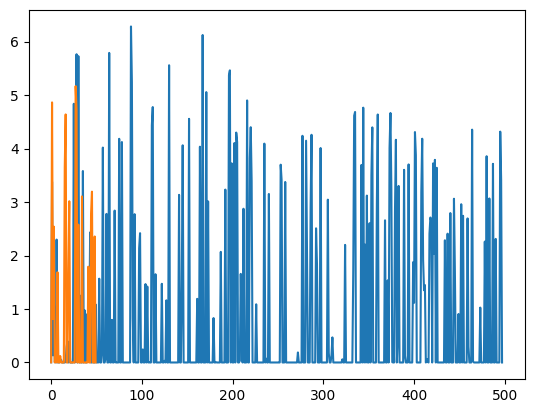

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)

In [ ]:
test_report=test['report'].iloc[1]

In [ ]:
completion=client.chat.completions.create(model='ft:gpt-3.5-turbo-0125:personal::BzFEcshi',
                                          messages=[
                                              {"role":"system","content":system_prompt},
                                              {"role":"user","content":test_report}
                                          ])

In [ ]:
completion.choices[0].message.content

'Cardiovascular / Pulmonary'

In [ ]:
system_prompt

'Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery'

In [ ]:
def classify_report(report,model):
  completion=client.chat.completions.create(model=model,
                                          messages=[
                                              {"role":"system","content":system_prompt},
                                              {"role":"user","content":report}
                                          ])
  return completion

In [ ]:
predicted_classes=[]
ground_truth_classes=[]

for line in test.iterrows():
  report,specialty=line[1]['report'],line[1]['medical_specialty']
  ground_truth_classes.append(specialty.strip())
  prediction=classify_report(report,model='ft:gpt-3.5-turbo-0125:personal::BzFEcshi')
  predicted_classes.append(prediction.choices[0].message.content.strip())


In [ ]:
import numpy as np
(np.array(predicted_classes)==np.array(ground_truth_classes)).mean()

np.float64(0.52)